## Packages

In [1]:
class array:

    def __init__(self):
        self.data = []

    def update(self, row):
        for r in row:
            self.data.append(r)

    def finalize(self):
        return np.reshape(self.data, newshape=(round(len(self.data)/1000), 1000))

In [2]:
from lasair import LasairError, lasair_client as lasair
from alerce.core import Alerce
import matplotlib.pyplot as plt
import sys, time
import requests
import numpy as np
import pandas as pd
import math
import time

import mysql.connector
import json
from collections import OrderedDict, Counter
import matplotlib.image as mpimg
import os
import csv
import io as StringIO

In [3]:
%%html
<style>
table {float:left}
</style>

## Functions

In [4]:
from ENID.acquisition import *
from ENID.interpolation import *
from ENID.lightcurve_plot import lightcurve_plot

List of functions that are used to run this notebook. These are custom, tailored for the purpose of searching for object names, retrieving light curves and plotting these in a way that suits our purposes.

In [4]:
#TNS                 = "sandbox.wis-tns.org"
#url_tns_api         = "https://" + TNS + "/api/get"

#TNS_BOT_ID          = "117327"
#TNS_BOT_NAME        = "ENID"
#TNS_API_KEY         = "0edfe1b95fd8f8e22102d531bb786d65fe1ce219"

#set_var(url_tns_api, TNS_BOT_ID, TNS_BOT_NAME, TNS_API_KEY)

# current working directory
#cwd                 = os.getcwd()
# directory for downloaded files
#download_dir        = os.path.join(cwd, "downloaded_files")

# external http errors
#ext_http_errors     = [403, 500, 503]
#err_msg             = ["Forbidden", "Internal Server Error: Something is broken", "Service Unavailable"]

#tns_marker = set_bot_tns_marker()
#headers = {'User-Agent': tns_marker}
#print(tns_marker, '\n')

## Alerce Query

We use the ALeRCE database to retrieve the ZTF source light curves. It requires installation of the alerce package. We also use the lasair package for some verifications. Initialisation of the two packages follows below.

In [5]:
alerce = Alerce()

token = !curl --data "username=Oliver&password=1234fisk" https://lasair-iris.roe.ac.uk/api/auth-token/
print(token[-1])

token = '591d4e074bca6a265191593cf4c0e8609e488e1b'
L = lasair(token)

{"token":"591d4e074bca6a265191593cf4c0e8609e488e1b"}


The filter ID in the ALeRCE database is related to the ZTF observation band on Lasair in the following way :

| Filter ID | Observation Band |
| :-: | :-: |
| 1 | G |
| 2 | R |

### Initial Query
We import the ZTF names of the sources that were identified as blue continuum from the Pessto+ marshall, and run a quick source search routine to determine which ones can be obtained from ALeRCE. As a back-up verification we also take the sources that were not found in the ALeRCE database and compare with Lasair-Iris.

In [6]:
Blu = pd.read_csv('BlueContinuumZTF.csv')
ztf_raw = list(Blu['ZTF Name'])
ztf_names = [x for x in ztf_raw if type(x) != float]

print('Number of sources :', len(ztf_raw), '\n')
alerce_found, alerce_missing = source_search_alerce(ztf_names)

print('Found ', alerce_found.shape[0], 'objects')
print('Missing ', len(alerce_missing), 'objects')

if len(alerce_missing) > 0:
    lasair_found, lasair_missing = source_search_lasair(alerce_missing)

alerce_found.head()

Number of sources : 55 

Found  55 objects
Missing  0 objects


,oid,ndethist,ncovhist,mjdstarthist,mjdendhist,corrected,stellar,ndet,g_r_max,g_r_max_corr,...,lastmjd,deltajd,meanra,meandec,sigmara,sigmadec,class,classifier,probability,step_id_corr
0,ZTF19abzwbxy,19,590,58747.277303,59354.443738,False,False,16,-0.288043,NaN,...,59354.443738,607.166435,305.860460,6.666890,0.000023,0.000026,None,None,None,correction_0.0.1
1,ZTF18abtuzsb,65,567,58368.229873,59464.233576,True,True,31,-0.186697,-0.072122,...,59464.233576,1096.003704,291.074024,-19.386080,0.000033,0.000037,None,None,None,correction_1.0.6
2,ZTF18abklbam,22,59,58331.163206,58475.492616,True,False,10,-0.033588,-0.017496,...,58475.492616,144.329410,217.829611,21.290207,0.000018,0.000017,None,None,None,corr_bulk_0.0.1
3,ZTF18abmdpwe,98,107,58340.320139,58433.074201,True,False,30,0.017229,0.199031,...,58433.074201,92.753148,275.659068,15.696555,0.000017,0.000022,None,None,None,corr_bulk_0.0.1
4,ZTF18abqbuaj,36,47,58356.407037,58372.358692,True,False,10,0.076601,0.174314,...,58372.358692,14.962002,20.253625,-13.862928,0.000019,0.000030,None,None,None,corr_bulk_0.0.1


### Lightcurve Retrieval

After having obtained metadata for the sources, we can retrieve the lightcurves and plot these. This is done for all 59 sources in order to verify which ones have enough data points to be used for classification. The sources are observed in two different bands, G and R, which are shown respectively in green and red. Non detections are not plotted, although they are extracted as well as the detections. 

For several sources, it seems that there are not enough data points for them to be used for classification. Interpolation is not an option due to lack of information about the overal lightcurve trend from the few detections.


Importing lightcurve and metadata for  ZTF19abzwbxy


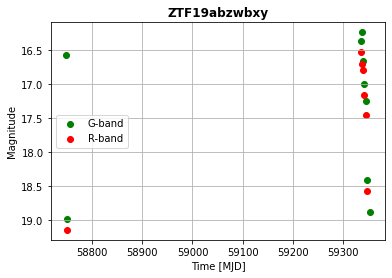


Importing lightcurve and metadata for  ZTF18abtuzsb


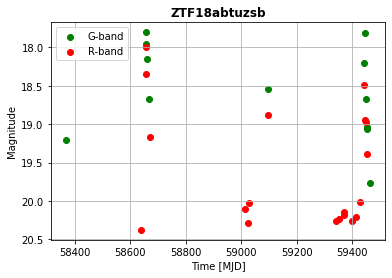


Importing lightcurve and metadata for  ZTF18abklbam


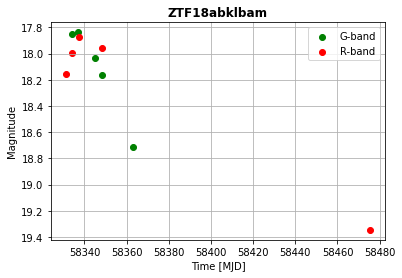


Importing lightcurve and metadata for  ZTF18abmdpwe


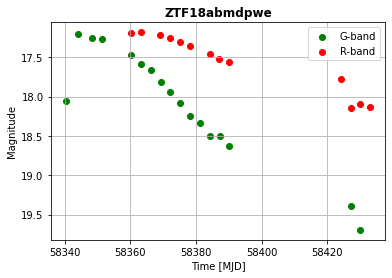


Importing lightcurve and metadata for  ZTF18abqbuaj


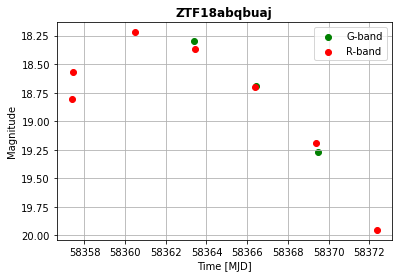

Features :  Index(['mjd', 'magpsf', 'sigmapsf', 'fid'], dtype='object')


In [7]:
sources = list(alerce_found['oid'])

for i in range(5):
    data, non_detection = alerce_retrieval(sources[i])
    lightcurve_plot(data, sources[i])

print('Features : ', data.columns)

## Class Query

For classification, we will need as large a dataset as possible. We can query ALeRCE to obtain the source IDs for a given class of transients. This output can then be used to pull whatever information we need (such as lightcurves). Below we perform a class query for SN Ia transients as an example.  

 Number of SNIa sources :  8138 

Importing lightcurve and metadata for  ZTF18abklbam


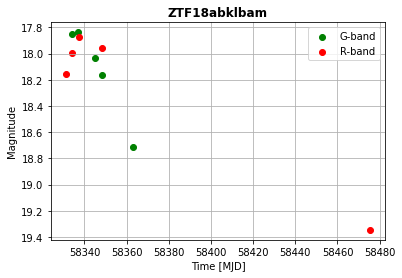

In [8]:
SNIa_oid = alerce_class_query(class_type='SNIa', num_detections=[10, 200], num_sources=10000)

SNIa_lc, SNIa_non_detections = alerce_retrieval('ZTF18abklbam')

lightcurve_plot(SNIa_lc, 'ZTF18abklbam')

In [9]:
dataset, savefile = dataset_gen('tns_public_objects.csv', 'lightcurves_1')


Importing lightcurve and metadata for  ZTF21acjbgok

Importing lightcurve and metadata for  ZTF21acizrpw

Importing lightcurve and metadata for  ZTF21aagolae

Importing lightcurve and metadata for  ZTF21acjgqjl

Importing lightcurve and metadata for  ZTF21acipdhn

Importing lightcurve and metadata for  ZTF21acipmgw

Importing lightcurve and metadata for  ZTF21aciobmz

Importing lightcurve and metadata for  ZTF21achltea

Importing lightcurve and metadata for  ZTF21acafsjy

Importing lightcurve and metadata for  ZTF21acaqdhq

Importing lightcurve and metadata for  ZTF21acjeegy

Importing lightcurve and metadata for  ZTF21acjbqrn

Importing lightcurve and metadata for  ZTF21acipvuz

Importing lightcurve and metadata for  ZTF21acindcq

Importing lightcurve and metadata for  ZTF21aciouwz

Importing lightcurve and metadata for  ZTF21acioxcf

Importing lightcurve and metadata for  ZTF21achzpyc

Importing lightcurve and metadata for  ZTF21achptrd

Importing lightcurve and metadata for  ZTF21a


Importing lightcurve and metadata for  ZTF21abfionl

Importing lightcurve and metadata for  ZTF21achxuuh

Importing lightcurve and metadata for  ZTF21achaxze

Importing lightcurve and metadata for  ZTF21aceynlp

Importing lightcurve and metadata for  ZTF21abvcxel

Importing lightcurve and metadata for  ZTF21achxlkq

Importing lightcurve and metadata for  ZTF21achqzub

Importing lightcurve and metadata for  ZTF21achauvx

Importing lightcurve and metadata for  ZTF21acgzgvm

Importing lightcurve and metadata for  ZTF21acgrero

Importing lightcurve and metadata for  ZTF21achpuoa

Importing lightcurve and metadata for  ZTF21achhwdz

Importing lightcurve and metadata for  ZTF21acgnagk

Importing lightcurve and metadata for  ZTF21achcwnd

Importing lightcurve and metadata for  ZTF21achdxdn

Importing lightcurve and metadata for  ZTF21aceyqog

Importing lightcurve and metadata for  ZTF21aceqrju

Importing lightcurve and metadata for  ZTF19aawlgne

Importing lightcurve and metadata for  ZTF19a


Importing lightcurve and metadata for  ZTF21abqvyyz

Importing lightcurve and metadata for  ZTF21abqhkjd

Importing lightcurve and metadata for  ZTF18acbygcu

Importing lightcurve and metadata for  ZTF21acdvban

Importing lightcurve and metadata for  ZTF21acdtosh

Importing lightcurve and metadata for  ZTF21abqikvn

Importing lightcurve and metadata for  ZTF21abmwmnp

Importing lightcurve and metadata for  ZTF21accteto

Importing lightcurve and metadata for  ZTF21acapxdf

Importing lightcurve and metadata for  ZTF21abxfyaw

Importing lightcurve and metadata for  ZTF21abvddpq

Importing lightcurve and metadata for  ZTF21acdzwjd

Importing lightcurve and metadata for  ZTF21acdmwae

Importing lightcurve and metadata for  ZTF21acdcxfz

Importing lightcurve and metadata for  ZTF18acdwuhy

Importing lightcurve and metadata for  ZTF21acbnfos

Importing lightcurve and metadata for  ZTF21abtxxjk

Importing lightcurve and metadata for  ZTF21abtsoky

Importing lightcurve and metadata for  ZTF21a


Importing lightcurve and metadata for  ZTF21abrzsol

Importing lightcurve and metadata for  ZTF21abplsmq

Importing lightcurve and metadata for  ZTF21abqmrtm

Importing lightcurve and metadata for  ZTF21abzgzvs

Importing lightcurve and metadata for  ZTF21abytufi

Importing lightcurve and metadata for  ZTF21abyazip

Importing lightcurve and metadata for  ZTF21abwxext

Importing lightcurve and metadata for  ZTF21abwqopp

Importing lightcurve and metadata for  ZTF21abxnghi

Importing lightcurve and metadata for  ZTF21abvrlup

Importing lightcurve and metadata for  ZTF21abmlldj

Importing lightcurve and metadata for  ZTF21abqgrqd

Importing lightcurve and metadata for  ZTF21abvdazf

Importing lightcurve and metadata for  ZTF21abvajfq

Importing lightcurve and metadata for  ZTF21abvicne

Importing lightcurve and metadata for  ZTF21abngbrl

Importing lightcurve and metadata for  ZTF21abwqhhc

Importing lightcurve and metadata for  ZTF21abxknvv

Importing lightcurve and metadata for  ZTF21a


Importing lightcurve and metadata for  ZTF21abutpwh

Importing lightcurve and metadata for  ZTF21abujejr

Importing lightcurve and metadata for  ZTF21abuetwv

Importing lightcurve and metadata for  ZTF21abtbygc

Importing lightcurve and metadata for  ZTF21abrxdrk

Importing lightcurve and metadata for  ZTF21abqsysj

Importing lightcurve and metadata for  ZTF21absbwyz

Importing lightcurve and metadata for  ZTF21abrpoaq

Importing lightcurve and metadata for  ZTF21abqjjrb

Importing lightcurve and metadata for  ZTF21abltdts

Importing lightcurve and metadata for  ZTF21abujmgh

Importing lightcurve and metadata for  ZTF21abtaxou

Importing lightcurve and metadata for  ZTF21absbrag

Importing lightcurve and metadata for  ZTF21abrhggj

Importing lightcurve and metadata for  ZTF18aasxwhv

Importing lightcurve and metadata for  ZTF21abuetqc

Importing lightcurve and metadata for  ZTF21abtfogg

Importing lightcurve and metadata for  ZTF21abuibjs

Importing lightcurve and metadata for  ZTF21a


Importing lightcurve and metadata for  ZTF21abkqvdo

Importing lightcurve and metadata for  ZTF21abicgai

Importing lightcurve and metadata for  ZTF21abiytsg

Importing lightcurve and metadata for  ZTF21abihsrg

Importing lightcurve and metadata for  ZTF21abfoxwp

Importing lightcurve and metadata for  ZTF21abccaue

Importing lightcurve and metadata for  ZTF21abhrlhn

Importing lightcurve and metadata for  ZTF20acxmxtu

Importing lightcurve and metadata for  ZTF21abpjpxr

Importing lightcurve and metadata for  ZTF21abouuow

Importing lightcurve and metadata for  ZTF21absbych

Importing lightcurve and metadata for  ZTF21aboyiaf

Importing lightcurve and metadata for  ZTF21abowxeh

Importing lightcurve and metadata for  ZTF21abjgzhn

Importing lightcurve and metadata for  ZTF21abmsppx

Importing lightcurve and metadata for  ZTF21ablwfcp

Importing lightcurve and metadata for  ZTF21abjhiqp

Importing lightcurve and metadata for  ZTF21abovblm

Importing lightcurve and metadata for  ZTF18a


Importing lightcurve and metadata for  ZTF21aanrhag

Importing lightcurve and metadata for  ZTF20acvfraq

Importing lightcurve and metadata for  ZTF20acrrssy

Importing lightcurve and metadata for  ZTF21abkinhh

Importing lightcurve and metadata for  ZTF21abmjivk

Importing lightcurve and metadata for  ZTF21abjwvzu

Importing lightcurve and metadata for  ZTF21abfxfqu

Importing lightcurve and metadata for  ZTF21abbxuez

Importing lightcurve and metadata for  ZTF21abkaoxe

Importing lightcurve and metadata for  ZTF21abilrxd

Importing lightcurve and metadata for  ZTF21abgcgem

Importing lightcurve and metadata for  ZTF21abfjlxb

Importing lightcurve and metadata for  ZTF20abarsvz

Importing lightcurve and metadata for  ZTF21abjciua

Importing lightcurve and metadata for  ZTF21abidikc

Importing lightcurve and metadata for  ZTF21abhqqfa

Importing lightcurve and metadata for  ZTF21abfmbix

Importing lightcurve and metadata for  ZTF21abbwajr

Importing lightcurve and metadata for  ZTF21a


Importing lightcurve and metadata for  ZTF21abidtrd

Importing lightcurve and metadata for  ZTF18aaqydat

Importing lightcurve and metadata for  ZTF21abcgnqn

Importing lightcurve and metadata for  ZTF21abiplqz

Importing lightcurve and metadata for  ZTF21abhzboh

Importing lightcurve and metadata for  ZTF21abhthvj

Importing lightcurve and metadata for  ZTF21abgywtg

Importing lightcurve and metadata for  ZTF21abgmyzw

Importing lightcurve and metadata for  ZTF21abfyxpf

Importing lightcurve and metadata for  ZTF21abfoace

Importing lightcurve and metadata for  ZTF21abdthxn

Importing lightcurve and metadata for  ZTF21abduoun

Importing lightcurve and metadata for  ZTF21abcrhpk

Importing lightcurve and metadata for  ZTF21abbzhvg

Importing lightcurve and metadata for  ZTF21abbkvrt

Importing lightcurve and metadata for  ZTF21abhqqwq

Importing lightcurve and metadata for  ZTF21abhthlm

Importing lightcurve and metadata for  ZTF21abbmcqq

Importing lightcurve and metadata for  ZTF21a


Importing lightcurve and metadata for  ZTF21aazqkeq

Importing lightcurve and metadata for  ZTF21abchhhx

Importing lightcurve and metadata for  ZTF21aakvrgb

Importing lightcurve and metadata for  ZTF21abdhetx

Importing lightcurve and metadata for  ZTF21abboibr

Importing lightcurve and metadata for  ZTF18aavvnzu

Importing lightcurve and metadata for  ZTF21aarytbc

Importing lightcurve and metadata for  ZTF21aasaxdk

Importing lightcurve and metadata for  ZTF21aanwmxn

Importing lightcurve and metadata for  ZTF21abezlqc

Importing lightcurve and metadata for  ZTF21abdveqn

Importing lightcurve and metadata for  ZTF20aanxcpf

Importing lightcurve and metadata for  ZTF21abcgufz

Importing lightcurve and metadata for  ZTF21abicckd

Importing lightcurve and metadata for  ZTF21aazlxiw

Importing lightcurve and metadata for  ZTF21aaxwnlr

Importing lightcurve and metadata for  ZTF21aauapli

Importing lightcurve and metadata for  ZTF21aawrrvn

Importing lightcurve and metadata for  ZTF21a


Importing lightcurve and metadata for  ZTF21aavhlok

Importing lightcurve and metadata for  ZTF21aauajgk

Importing lightcurve and metadata for  ZTF21aatwkkt

Importing lightcurve and metadata for  ZTF21aatpsky

Importing lightcurve and metadata for  ZTF21aatkdcw

Importing lightcurve and metadata for  ZTF19abcfvpv

Importing lightcurve and metadata for  ZTF21aalodzw

Importing lightcurve and metadata for  ZTF21aaxkckg

Importing lightcurve and metadata for  ZTF21abceehu

Importing lightcurve and metadata for  ZTF21abaputv

Importing lightcurve and metadata for  ZTF21aaydxoo

Importing lightcurve and metadata for  ZTF21aaxlhyl

Importing lightcurve and metadata for  ZTF21aasyzkt

Importing lightcurve and metadata for  ZTF21abbjybk

Importing lightcurve and metadata for  ZTF21aazbico

Importing lightcurve and metadata for  ZTF20acgyjbh

Importing lightcurve and metadata for  ZTF20aadymod

Importing lightcurve and metadata for  ZTF21abaakwd

Importing lightcurve and metadata for  ZTF21a


Importing lightcurve and metadata for  ZTF21aaxtrlt

Importing lightcurve and metadata for  ZTF21aaxlbad

Importing lightcurve and metadata for  ZTF21aavodst

Importing lightcurve and metadata for  ZTF21aavxivm

Importing lightcurve and metadata for  ZTF21aavqphe

Importing lightcurve and metadata for  ZTF21aaswtok

Importing lightcurve and metadata for  ZTF21aapxogj

Importing lightcurve and metadata for  ZTF21aalimya

Importing lightcurve and metadata for  ZTF21aafkwtk

Importing lightcurve and metadata for  ZTF21aaymnuc

Importing lightcurve and metadata for  ZTF21aaublej

Importing lightcurve and metadata for  ZTF21aarasvn

Importing lightcurve and metadata for  ZTF21aarhzdh

Importing lightcurve and metadata for  ZTF21aaxycms

Importing lightcurve and metadata for  ZTF21aaxtctv

Importing lightcurve and metadata for  ZTF21aaxjpsw

Importing lightcurve and metadata for  ZTF21aauvmck

Importing lightcurve and metadata for  ZTF21aatdzmt

Importing lightcurve and metadata for  ZTF21a


Importing lightcurve and metadata for  ZTF21aatvqcl

Importing lightcurve and metadata for  ZTF21aatjavc

Importing lightcurve and metadata for  ZTF21aasgcve

Importing lightcurve and metadata for  ZTF21aasbkrl

Importing lightcurve and metadata for  ZTF21aareexg

Importing lightcurve and metadata for  ZTF21aapowty

Importing lightcurve and metadata for  ZTF21aappkns

Importing lightcurve and metadata for  ZTF21aanvncv

Importing lightcurve and metadata for  ZTF21aalydkl

Importing lightcurve and metadata for  ZTF21aalhgqi

Importing lightcurve and metadata for  ZTF21aakvroo

Importing lightcurve and metadata for  ZTF21aauamtx

Importing lightcurve and metadata for  ZTF21aatlbsi

Importing lightcurve and metadata for  ZTF21aaswvyc

Importing lightcurve and metadata for  ZTF21aarlqgt

Importing lightcurve and metadata for  ZTF20acqntkr

Importing lightcurve and metadata for  ZTF21aaxbube

Importing lightcurve and metadata for  ZTF21aaupkow

Importing lightcurve and metadata for  ZTF21a


Importing lightcurve and metadata for  ZTF21aapejbx

Importing lightcurve and metadata for  ZTF21aalxurx

Importing lightcurve and metadata for  ZTF21aagtvjq

Importing lightcurve and metadata for  ZTF21aaaokyp

Importing lightcurve and metadata for  ZTF20acyroke

Importing lightcurve and metadata for  ZTF21aappehx

Importing lightcurve and metadata for  ZTF21aaplnef

Importing lightcurve and metadata for  ZTF21aanswls

Importing lightcurve and metadata for  ZTF21aagtekf

Importing lightcurve and metadata for  ZTF21aaoqefp

Importing lightcurve and metadata for  ZTF21aaqafcf

Importing lightcurve and metadata for  ZTF21aapegtd

Importing lightcurve and metadata for  ZTF21aaphvyi

Importing lightcurve and metadata for  ZTF21aantsla

Importing lightcurve and metadata for  ZTF21aagtuzm

Importing lightcurve and metadata for  ZTF21aapomdb

Importing lightcurve and metadata for  ZTF21aaodljj

Importing lightcurve and metadata for  ZTF21aahfjrr

Importing lightcurve and metadata for  ZTF21a


Importing lightcurve and metadata for  ZTF20acowata

Importing lightcurve and metadata for  ZTF21aalnhby

Importing lightcurve and metadata for  ZTF21aaflzqy

Importing lightcurve and metadata for  ZTF21aacknob

Importing lightcurve and metadata for  ZTF20actkulc

Importing lightcurve and metadata for  ZTF21aanyfqu

Importing lightcurve and metadata for  ZTF21aanwfjk

Importing lightcurve and metadata for  ZTF21aajaljq

Importing lightcurve and metadata for  ZTF21aakbgpf

Importing lightcurve and metadata for  ZTF18aatgdph

Importing lightcurve and metadata for  ZTF21aagtceu

Importing lightcurve and metadata for  ZTF20acyydkh

Importing lightcurve and metadata for  ZTF21aanplys

Importing lightcurve and metadata for  ZTF21aanfuuk

Importing lightcurve and metadata for  ZTF21aalxurs

Importing lightcurve and metadata for  ZTF21aaczpca

Importing lightcurve and metadata for  ZTF21aamwzfi

Importing lightcurve and metadata for  ZTF21aalekwo

Importing lightcurve and metadata for  ZTF21a


Importing lightcurve and metadata for  ZTF20adadrhw

Importing lightcurve and metadata for  ZTF20actqnhg

Importing lightcurve and metadata for  ZTF20acpgnej

Importing lightcurve and metadata for  ZTF21aaigqir

Importing lightcurve and metadata for  ZTF19aakppnj

Importing lightcurve and metadata for  ZTF20acxncha

Importing lightcurve and metadata for  ZTF20acynllu

Importing lightcurve and metadata for  ZTF20acwujgz

Importing lightcurve and metadata for  ZTF20acuosvy

Importing lightcurve and metadata for  ZTF20actskcf

Importing lightcurve and metadata for  ZTF20actpqgc

Importing lightcurve and metadata for  ZTF20acufmte

Importing lightcurve and metadata for  ZTF20acrcewc

Importing lightcurve and metadata for  ZTF20actiymd

Importing lightcurve and metadata for  ZTF20acrerzb

Importing lightcurve and metadata for  ZTF20acqzpta

Importing lightcurve and metadata for  ZTF20acpjcoe

Importing lightcurve and metadata for  ZTF20acqksdi

Importing lightcurve and metadata for  ZTF20a


Importing lightcurve and metadata for  ZTF20acusecr

Importing lightcurve and metadata for  ZTF20acrdadi

Importing lightcurve and metadata for  ZTF20acpbdvm

Importing lightcurve and metadata for  ZTF20aclwclm

Importing lightcurve and metadata for  ZTF20aatwyzg

Importing lightcurve and metadata for  ZTF21aahaksd

Importing lightcurve and metadata for  ZTF21aaglamm

Importing lightcurve and metadata for  ZTF21aaglrfh

Importing lightcurve and metadata for  ZTF21aagmoqw

Importing lightcurve and metadata for  ZTF21aaekmoy

Importing lightcurve and metadata for  ZTF21aaabucr

Importing lightcurve and metadata for  ZTF21aagydov

Importing lightcurve and metadata for  ZTF21aagogqj

Importing lightcurve and metadata for  ZTF21aaglret

Importing lightcurve and metadata for  ZTF21aagkhwf

Importing lightcurve and metadata for  ZTF21aafdxca

Importing lightcurve and metadata for  ZTF18aafzers

Importing lightcurve and metadata for  ZTF21aaewexx

Importing lightcurve and metadata for  ZTF21a


Importing lightcurve and metadata for  ZTF20acwoamm

Importing lightcurve and metadata for  ZTF20acusqsp

Importing lightcurve and metadata for  ZTF20aasjzhg

Importing lightcurve and metadata for  ZTF21aaasxel

Importing lightcurve and metadata for  ZTF21aadoizf

Importing lightcurve and metadata for  ZTF21aacscvb

Importing lightcurve and metadata for  ZTF21aabyqps

Importing lightcurve and metadata for  ZTF21aaahuox

Importing lightcurve and metadata for  ZTF21aabfwwl

Importing lightcurve and metadata for  ZTF21aabcyvd

Importing lightcurve and metadata for  ZTF21aaaosmn

Importing lightcurve and metadata for  ZTF21aaaaddl

Importing lightcurve and metadata for  ZTF20acywbes

Importing lightcurve and metadata for  ZTF20acyyavb

Importing lightcurve and metadata for  ZTF21aaaadvr

Importing lightcurve and metadata for  ZTF21aaavhbu

Importing lightcurve and metadata for  ZTF21aadkhte

Importing lightcurve and metadata for  ZTF21aaahzpr

Importing lightcurve and metadata for  ZTF20a


Importing lightcurve and metadata for  ZTF20acmddof

Importing lightcurve and metadata for  ZTF20aciuapp

Importing lightcurve and metadata for  ZTF20acinaeq

Importing lightcurve and metadata for  ZTF20acifzof

Importing lightcurve and metadata for  ZTF20abykfsr

Importing lightcurve and metadata for  ZTF20abpuwxl

Importing lightcurve and metadata for  ZTF20acuzlib

Importing lightcurve and metadata for  ZTF20acuimtq

Importing lightcurve and metadata for  ZTF20actawpa

Importing lightcurve and metadata for  ZTF20acrbqnp

Importing lightcurve and metadata for  ZTF20acpwjus

Importing lightcurve and metadata for  ZTF20acpkqhq

Importing lightcurve and metadata for  ZTF20acoxmsr

Importing lightcurve and metadata for  ZTF20acosehg

Importing lightcurve and metadata for  ZTF20aciuciv

Importing lightcurve and metadata for  ZTF20achkgng

Importing lightcurve and metadata for  ZTF20acogywb

Importing lightcurve and metadata for  ZTF20acwcqnv

Importing lightcurve and metadata for  ZTF20a


Importing lightcurve and metadata for  ZTF20actvgsy

Importing lightcurve and metadata for  ZTF20acordqz

Importing lightcurve and metadata for  ZTF20accmutv

Importing lightcurve and metadata for  ZTF20acumekm

Importing lightcurve and metadata for  ZTF20acuhren

Importing lightcurve and metadata for  ZTF20acuaqlf

Importing lightcurve and metadata for  ZTF20acrxrfv

Importing lightcurve and metadata for  ZTF20actfeym

Importing lightcurve and metadata for  ZTF20acsesce

Importing lightcurve and metadata for  ZTF20acrudzk

Importing lightcurve and metadata for  ZTF20acphcdv

Importing lightcurve and metadata for  ZTF20acphccy

Importing lightcurve and metadata for  ZTF20acrbpqd

Importing lightcurve and metadata for  ZTF20acpumut

Importing lightcurve and metadata for  ZTF20acpqagp

Importing lightcurve and metadata for  ZTF20acpksoc

Importing lightcurve and metadata for  ZTF20acpkled

Importing lightcurve and metadata for  ZTF20acpgzif

Importing lightcurve and metadata for  ZTF20a


Importing lightcurve and metadata for  ZTF18aagrdcs

Importing lightcurve and metadata for  ZTF20acrheie

Importing lightcurve and metadata for  ZTF20acqfssi

Importing lightcurve and metadata for  ZTF20acpkmtf

Importing lightcurve and metadata for  ZTF20aciubfx

Importing lightcurve and metadata for  ZTF20achvdtx

Importing lightcurve and metadata for  ZTF19aaaojck

Importing lightcurve and metadata for  ZTF18aabxlsv

Importing lightcurve and metadata for  ZTF20acpjapi

Importing lightcurve and metadata for  ZTF20acpjbgc

Importing lightcurve and metadata for  ZTF20acphdcg

Importing lightcurve and metadata for  ZTF20aclvtnk

Importing lightcurve and metadata for  ZTF20acpujxl

Importing lightcurve and metadata for  ZTF20aclkdlu

Importing lightcurve and metadata for  ZTF20acstbfh

Importing lightcurve and metadata for  ZTF20acpmxdg

Importing lightcurve and metadata for  ZTF19acwiqrc

Importing lightcurve and metadata for  ZTF20acnznol

Importing lightcurve and metadata for  ZTF20a


Importing lightcurve and metadata for  ZTF20acmxpmg

Importing lightcurve and metadata for  ZTF20acnvlgg

Importing lightcurve and metadata for  ZTF20acnwgtl

Importing lightcurve and metadata for  ZTF20ackkejs

Importing lightcurve and metadata for  ZTF20acgyulx

Importing lightcurve and metadata for  ZTF20acgprcg

Importing lightcurve and metadata for  ZTF20acgdycd

Importing lightcurve and metadata for  ZTF20aceyolc

Importing lightcurve and metadata for  ZTF20abyzoof

Importing lightcurve and metadata for  ZTF20abxawtg

Importing lightcurve and metadata for  ZTF20abxtiyh

Importing lightcurve and metadata for  ZTF20aazlsqn

Importing lightcurve and metadata for  ZTF20acgzjje

Importing lightcurve and metadata for  ZTF20abswdbg

Importing lightcurve and metadata for  ZTF20acmntog

Importing lightcurve and metadata for  ZTF20acixidp

Importing lightcurve and metadata for  ZTF20achoqvb

Importing lightcurve and metadata for  ZTF20acklcyp

Importing lightcurve and metadata for  ZTF20a


Importing lightcurve and metadata for  ZTF20abjwjrx

Importing lightcurve and metadata for  ZTF20abgbxby

Importing lightcurve and metadata for  ZTF20abawhtd

Importing lightcurve and metadata for  ZTF20aavkomc

Importing lightcurve and metadata for  ZTF20acinuir

Importing lightcurve and metadata for  ZTF20achdcni

Importing lightcurve and metadata for  ZTF20achtxbi

Importing lightcurve and metadata for  ZTF20acgmqgv

Importing lightcurve and metadata for  ZTF20acgremo

Importing lightcurve and metadata for  ZTF20acgmvsn

Importing lightcurve and metadata for  ZTF19aarmtgu

Importing lightcurve and metadata for  ZTF20acghajc

Importing lightcurve and metadata for  ZTF20accodxy

Importing lightcurve and metadata for  ZTF18abvoyen

Importing lightcurve and metadata for  ZTF20acdnmpv

Importing lightcurve and metadata for  ZTF20acajvrj

Importing lightcurve and metadata for  ZTF20abzfoyg

Importing lightcurve and metadata for  ZTF20abyskia

Importing lightcurve and metadata for  ZTF20a


Importing lightcurve and metadata for  ZTF20accagnf

Importing lightcurve and metadata for  ZTF20abzhwtq

Importing lightcurve and metadata for  ZTF20abpmqnr

Importing lightcurve and metadata for  ZTF20acbnwyb

Importing lightcurve and metadata for  ZTF20abyrmdl

Importing lightcurve and metadata for  ZTF20abyxnjo

Importing lightcurve and metadata for  ZTF20abzettb

Importing lightcurve and metadata for  ZTF20abyxcib

Importing lightcurve and metadata for  ZTF20abyqdyg

Importing lightcurve and metadata for  ZTF20abnofwd

Importing lightcurve and metadata for  ZTF20abpuxcc

Importing lightcurve and metadata for  ZTF20abxyaxt

Importing lightcurve and metadata for  ZTF20abmmkyv

Importing lightcurve and metadata for  ZTF20abkhjdq

Importing lightcurve and metadata for  ZTF20abzjvse

Importing lightcurve and metadata for  ZTF20abzcokv

Importing lightcurve and metadata for  ZTF20abyznqs

Importing lightcurve and metadata for  ZTF20abzayoe

Importing lightcurve and metadata for  ZTF20a


Importing lightcurve and metadata for  ZTF20abvxhvg

Importing lightcurve and metadata for  ZTF20abqmmhn

Importing lightcurve and metadata for  ZTF20abtajxq

Importing lightcurve and metadata for  ZTF20abuojuw

Importing lightcurve and metadata for  ZTF20abtkjfw

Importing lightcurve and metadata for  ZTF20abrdvpj

Importing lightcurve and metadata for  ZTF20aaskdhj

Importing lightcurve and metadata for  ZTF20aattztb

Importing lightcurve and metadata for  ZTF20aaivhra

Importing lightcurve and metadata for  ZTF20aahapgw

Importing lightcurve and metadata for  ZTF20aaaddgy

Importing lightcurve and metadata for  ZTF19acftbsn

Importing lightcurve and metadata for  ZTF20absfrbq

Importing lightcurve and metadata for  ZTF20abfcszi

Importing lightcurve and metadata for  ZTF19acbjddp

Importing lightcurve and metadata for  ZTF19ablpasc

Importing lightcurve and metadata for  ZTF19aavsrgj

Importing lightcurve and metadata for  ZTF19aaoxfyh

Importing lightcurve and metadata for  ZTF19a


Importing lightcurve and metadata for  ZTF20abndzyc

Importing lightcurve and metadata for  ZTF20abmzfql

Importing lightcurve and metadata for  ZTF20abkloyg

Importing lightcurve and metadata for  ZTF20abjpvce

Importing lightcurve and metadata for  ZTF20ablvukx

Importing lightcurve and metadata for  ZTF20abkgypx

Importing lightcurve and metadata for  ZTF20abjubmm

Importing lightcurve and metadata for  ZTF18acjwspf

Importing lightcurve and metadata for  ZTF20abijfqq

Importing lightcurve and metadata for  ZTF20abhjwvh

Importing lightcurve and metadata for  ZTF18abttsrb

Importing lightcurve and metadata for  ZTF19aasqseq

Importing lightcurve and metadata for  ZTF19aarrdoz

Importing lightcurve and metadata for  ZTF19aanfsmc

Importing lightcurve and metadata for  ZTF19abalbim

Importing lightcurve and metadata for  ZTF18abmxelh

Importing lightcurve and metadata for  ZTF19abhhdwf

Importing lightcurve and metadata for  ZTF19abrdxbh

Importing lightcurve and metadata for  ZTF19a


Importing lightcurve and metadata for  ZTF20abipuee

Importing lightcurve and metadata for  ZTF20abhmnom

Importing lightcurve and metadata for  ZTF20abhmqdn

Importing lightcurve and metadata for  ZTF20abhvnzc

Importing lightcurve and metadata for  ZTF20abguygh

Importing lightcurve and metadata for  ZTF20aaycmhl

Importing lightcurve and metadata for  ZTF20abhlncz

Importing lightcurve and metadata for  ZTF20abhrmxh

Importing lightcurve and metadata for  ZTF20abgaovd

Importing lightcurve and metadata for  ZTF20abgpksj

Importing lightcurve and metadata for  ZTF20abgoocl

Importing lightcurve and metadata for  ZTF20abgfvav

Importing lightcurve and metadata for  ZTF20abgzvff

Importing lightcurve and metadata for  ZTF20abgfljj

Importing lightcurve and metadata for  ZTF20abgwfek

Importing lightcurve and metadata for  ZTF19aamdmcs

Importing lightcurve and metadata for  ZTF20abgakbv

Importing lightcurve and metadata for  ZTF20abfsemq

Importing lightcurve and metadata for  ZTF20a


Importing lightcurve and metadata for  ZTF20abbpkpa

Importing lightcurve and metadata for  ZTF20abbpkng

Importing lightcurve and metadata for  ZTF20abawtpy

Importing lightcurve and metadata for  ZTF20abbeeyt

Importing lightcurve and metadata for  ZTF20abawntz

Importing lightcurve and metadata for  ZTF20abavnaw

Importing lightcurve and metadata for  ZTF20aazwuin

Importing lightcurve and metadata for  ZTF20abbhyxu

Importing lightcurve and metadata for  ZTF20abaunmw

Importing lightcurve and metadata for  ZTF20abbqfoi

Importing lightcurve and metadata for  ZTF20abbhrrt

Importing lightcurve and metadata for  ZTF20abajsne

Importing lightcurve and metadata for  ZTF18abhbqbh

Importing lightcurve and metadata for  ZTF20abbbumr

Importing lightcurve and metadata for  ZTF20abbblms

Importing lightcurve and metadata for  ZTF20abajtzc

Importing lightcurve and metadata for  ZTF20abasqfx

Importing lightcurve and metadata for  ZTF20abatfzl

Importing lightcurve and metadata for  ZTF20a


Importing lightcurve and metadata for  ZTF20aaxxepr

Importing lightcurve and metadata for  ZTF20ablqacl

Importing lightcurve and metadata for  ZTF20aaydgsu

Importing lightcurve and metadata for  ZTF20aaxunbm

Importing lightcurve and metadata for  ZTF20aaxfzhw

Importing lightcurve and metadata for  ZTF20aaxmtxg

Importing lightcurve and metadata for  ZTF20aaxxcms

Importing lightcurve and metadata for  ZTF18aahatvc

Importing lightcurve and metadata for  ZTF20aaxvzja

Importing lightcurve and metadata for  ZTF20aaxxhib

Importing lightcurve and metadata for  ZTF20aaxccrm

Importing lightcurve and metadata for  ZTF20aaxbvkt

Importing lightcurve and metadata for  ZTF20aavynba

Importing lightcurve and metadata for  ZTF20aawadcp

Importing lightcurve and metadata for  ZTF20aaxablt

Importing lightcurve and metadata for  ZTF20aaxahpk

Importing lightcurve and metadata for  ZTF20aawqywr

Importing lightcurve and metadata for  ZTF20aaxhzhc

Importing lightcurve and metadata for  ZTF20a


Importing lightcurve and metadata for  ZTF20aaukudw

Importing lightcurve and metadata for  ZTF20aaummmc

Importing lightcurve and metadata for  ZTF20aaumlmu

Importing lightcurve and metadata for  ZTF20aaumnfl

Importing lightcurve and metadata for  ZTF20aaunfpj

Importing lightcurve and metadata for  ZTF20aatzhhl

Importing lightcurve and metadata for  ZTF20aatvupb

Importing lightcurve and metadata for  ZTF18aakiwbs

Importing lightcurve and metadata for  ZTF20aatxnxq

Importing lightcurve and metadata for  ZTF20aatvzmm

Importing lightcurve and metadata for  ZTF20aatqief

Importing lightcurve and metadata for  ZTF20aatppnn

Importing lightcurve and metadata for  ZTF18aarlpzd

Importing lightcurve and metadata for  ZTF20aattrld

Importing lightcurve and metadata for  ZTF20aatzwgk

Importing lightcurve and metadata for  ZTF20aatulug

Importing lightcurve and metadata for  ZTF20aatqgeo

Importing lightcurve and metadata for  ZTF20aattotq

Importing lightcurve and metadata for  ZTF20a


Importing lightcurve and metadata for  ZTF20aapcbmc

Importing lightcurve and metadata for  ZTF20aaqpxtm

Importing lightcurve and metadata for  ZTF18abifioh

Importing lightcurve and metadata for  ZTF20aapnqbw

Importing lightcurve and metadata for  ZTF20aaosuzy

Importing lightcurve and metadata for  ZTF20aasivpe

Importing lightcurve and metadata for  ZTF20aaqukzi

Importing lightcurve and metadata for  ZTF20aapadwx

Importing lightcurve and metadata for  ZTF20aapcmur

Importing lightcurve and metadata for  ZTF20aaogrqe

Importing lightcurve and metadata for  ZTF20aaoldej

Importing lightcurve and metadata for  ZTF20aaosoct

Importing lightcurve and metadata for  ZTF20aaqbach

Importing lightcurve and metadata for  ZTF20aapycrh

Importing lightcurve and metadata for  ZTF20aapjiwl

Importing lightcurve and metadata for  ZTF20aaowuim

Importing lightcurve and metadata for  ZTF20aappghn

Importing lightcurve and metadata for  ZTF20aappcup

Importing lightcurve and metadata for  ZTF20a


Importing lightcurve and metadata for  ZTF18aaybfsd

Importing lightcurve and metadata for  ZTF20aambbfn

Importing lightcurve and metadata for  ZTF20aamhocj

Importing lightcurve and metadata for  ZTF20aamdyal

Importing lightcurve and metadata for  ZTF20aamdqiz

Importing lightcurve and metadata for  ZTF20aamaqak

Importing lightcurve and metadata for  ZTF20aamfpcj

Importing lightcurve and metadata for  ZTF20aamdyln

Importing lightcurve and metadata for  ZTF18aarvjhs

Importing lightcurve and metadata for  ZTF20aalrksw

Importing lightcurve and metadata for  ZTF20aamcvyp

Importing lightcurve and metadata for  ZTF20aamazzl

Importing lightcurve and metadata for  ZTF20aalxlis

Importing lightcurve and metadata for  ZTF20aaljgcp

Importing lightcurve and metadata for  ZTF20aalyeut

Importing lightcurve and metadata for  ZTF18abhgrff

Importing lightcurve and metadata for  ZTF18aaaibml

Importing lightcurve and metadata for  ZTF20aajbsxt

Importing lightcurve and metadata for  ZTF20a


Importing lightcurve and metadata for  ZTF20aahqabk

Importing lightcurve and metadata for  ZTF20aagqrbx

Importing lightcurve and metadata for  ZTF20aagnbpw

Importing lightcurve and metadata for  ZTF20aaglivt

Importing lightcurve and metadata for  ZTF20aagjpmt

Importing lightcurve and metadata for  ZTF20aagnbes

Importing lightcurve and metadata for  ZTF20aafcnem

Importing lightcurve and metadata for  ZTF20aaflaug

Importing lightcurve and metadata for  ZTF20aafrihv

Importing lightcurve and metadata for  ZTF19abeizmo

Importing lightcurve and metadata for  ZTF17aadlxmv

Importing lightcurve and metadata for  ZTF20aagwczh

Importing lightcurve and metadata for  ZTF20aafrjqw

Importing lightcurve and metadata for  ZTF20aagewqr

Importing lightcurve and metadata for  ZTF20aafvzhu

Importing lightcurve and metadata for  ZTF20aaghpdc

Importing lightcurve and metadata for  ZTF20aagfjlj

Importing lightcurve and metadata for  ZTF20aafjjqj

Importing lightcurve and metadata for  ZTF20a


Importing lightcurve and metadata for  ZTF20aaaxacu

Importing lightcurve and metadata for  ZTF19adcdtyy

Importing lightcurve and metadata for  ZTF20aacciep

Importing lightcurve and metadata for  ZTF20aadyqdh

Importing lightcurve and metadata for  ZTF19adcdtkw

Importing lightcurve and metadata for  ZTF19adccrca

Importing lightcurve and metadata for  ZTF19adcfsoc

Importing lightcurve and metadata for  ZTF19adcfsdr

Importing lightcurve and metadata for  ZTF19adbmwto

Importing lightcurve and metadata for  ZTF19adcdgca

Importing lightcurve and metadata for  ZTF18aaizerg

Importing lightcurve and metadata for  ZTF19adcdzjm

Importing lightcurve and metadata for  ZTF19adcdrng

Importing lightcurve and metadata for  ZTF19adcbxkw

Importing lightcurve and metadata for  ZTF19adccckb

Importing lightcurve and metadata for  ZTF19adbpulv

Importing lightcurve and metadata for  ZTF19adcghvg

Importing lightcurve and metadata for  ZTF20aabconi

Importing lightcurve and metadata for  ZTF20a


Importing lightcurve and metadata for  ZTF19acvdyyn

Importing lightcurve and metadata for  ZTF19acxzdht

Importing lightcurve and metadata for  ZTF19acxzafe

Importing lightcurve and metadata for  ZTF19acxmiyh

Importing lightcurve and metadata for  ZTF19acxniuc

Importing lightcurve and metadata for  ZTF19acylgic

Importing lightcurve and metadata for  ZTF19acxrihd

Importing lightcurve and metadata for  ZTF19acyfoha

Importing lightcurve and metadata for  ZTF18abakunn

Importing lightcurve and metadata for  ZTF19acyltbi

Importing lightcurve and metadata for  ZTF19acxmmys

Importing lightcurve and metadata for  ZTF19acxldra

Importing lightcurve and metadata for  ZTF19acxowwt

Importing lightcurve and metadata for  ZTF19aafwrhf

Importing lightcurve and metadata for  ZTF19acxndsk

Importing lightcurve and metadata for  ZTF19acxowrr

Importing lightcurve and metadata for  ZTF19acxozhr

Importing lightcurve and metadata for  ZTF19acxmpnz

Importing lightcurve and metadata for  ZTF19a


Importing lightcurve and metadata for  ZTF19acshkft

Importing lightcurve and metadata for  ZTF19acrenwk

Importing lightcurve and metadata for  ZTF19actfpmy

Importing lightcurve and metadata for  ZTF19acspfcb

Importing lightcurve and metadata for  ZTF19acsfvog

Importing lightcurve and metadata for  ZTF19acqypso

Importing lightcurve and metadata for  ZTF19acoyxuv

Importing lightcurve and metadata for  ZTF19acsbxem

Importing lightcurve and metadata for  ZTF19ackjvtl

Importing lightcurve and metadata for  ZTF19acmxymo

Importing lightcurve and metadata for  ZTF19acsfpmi

Importing lightcurve and metadata for  ZTF20aacbyij

Importing lightcurve and metadata for  ZTF19acrwzqs

Importing lightcurve and metadata for  ZTF19acryurj

Importing lightcurve and metadata for  ZTF19acryaon

Importing lightcurve and metadata for  ZTF19acrwyyb

Importing lightcurve and metadata for  ZTF19acrwvao

Importing lightcurve and metadata for  ZTF19acruqph

Importing lightcurve and metadata for  ZTF19a


Importing lightcurve and metadata for  ZTF19aclhnkd

Importing lightcurve and metadata for  ZTF19achajnc

Importing lightcurve and metadata for  ZTF19acjuomg

Importing lightcurve and metadata for  ZTF19ackjszs

Importing lightcurve and metadata for  ZTF19acjerdh

Importing lightcurve and metadata for  ZTF19acgpkye

Importing lightcurve and metadata for  ZTF19acfsbpa

Importing lightcurve and metadata for  ZTF19ackjmge

Importing lightcurve and metadata for  ZTF19acjjwsy

Importing lightcurve and metadata for  ZTF19acjutrw

Importing lightcurve and metadata for  ZTF19acjtpqd

Importing lightcurve and metadata for  ZTF19acjtpmm

Importing lightcurve and metadata for  ZTF19acjtkha

Importing lightcurve and metadata for  ZTF19aclhohd

Importing lightcurve and metadata for  ZTF19ackbclh

Importing lightcurve and metadata for  ZTF19acjtlxe

Importing lightcurve and metadata for  ZTF19acjfhom

Importing lightcurve and metadata for  ZTF19achejoc

Importing lightcurve and metadata for  ZTF19a


Importing lightcurve and metadata for  ZTF19acfthre

Importing lightcurve and metadata for  ZTF19acftfav

Importing lightcurve and metadata for  ZTF18acfhmdg

Importing lightcurve and metadata for  ZTF19acewotx

Importing lightcurve and metadata for  ZTF19aceuacu

Importing lightcurve and metadata for  ZTF19acdxlns

Importing lightcurve and metadata for  ZTF19acgjphi

Importing lightcurve and metadata for  ZTF19acduqvr

Importing lightcurve and metadata for  ZTF19acfduxa

Importing lightcurve and metadata for  ZTF19acecluy

Importing lightcurve and metadata for  ZTF19acftaml

Importing lightcurve and metadata for  ZTF19acgonwy

Importing lightcurve and metadata for  ZTF19acexijn

Importing lightcurve and metadata for  ZTF19acfejbj

Importing lightcurve and metadata for  ZTF19acenveq

Importing lightcurve and metadata for  ZTF19acetxvq

Importing lightcurve and metadata for  ZTF19acekreh

Importing lightcurve and metadata for  ZTF19aceshib

Importing lightcurve and metadata for  ZTF19a


Importing lightcurve and metadata for  ZTF19acbmwtc

Importing lightcurve and metadata for  ZTF19acbmqpu

Importing lightcurve and metadata for  ZTF19acbmojx

Importing lightcurve and metadata for  ZTF19acbmddl

Importing lightcurve and metadata for  ZTF19acblzux

Importing lightcurve and metadata for  ZTF19acblhgq

Importing lightcurve and metadata for  ZTF19acblqjf

Importing lightcurve and metadata for  ZTF19abzrjrg

Importing lightcurve and metadata for  ZTF19acbtcyx

Importing lightcurve and metadata for  ZTF19acbacvu

Importing lightcurve and metadata for  ZTF19acazaug

Importing lightcurve and metadata for  ZTF19acbiwjk

Importing lightcurve and metadata for  ZTF19acblhxc

Importing lightcurve and metadata for  ZTF19acbkczc

Importing lightcurve and metadata for  ZTF19acbjlnt

Importing lightcurve and metadata for  ZTF19acaxcwg

Importing lightcurve and metadata for  ZTF19acccyxx

Importing lightcurve and metadata for  ZTF19acblnop

Importing lightcurve and metadata for  ZTF19a


Importing lightcurve and metadata for  ZTF19abvjcii

Importing lightcurve and metadata for  ZTF19abwaohs

Importing lightcurve and metadata for  ZTF19abwsagv

Importing lightcurve and metadata for  ZTF19abxnycf

Importing lightcurve and metadata for  ZTF19abxihut

Importing lightcurve and metadata for  ZTF19abxigfc

Importing lightcurve and metadata for  ZTF19abuzpmr

Importing lightcurve and metadata for  ZTF19abwsecm

Importing lightcurve and metadata for  ZTF19abxjrge

Importing lightcurve and metadata for  ZTF19abvgwvp

Importing lightcurve and metadata for  ZTF19abrvagn

Importing lightcurve and metadata for  ZTF19abvhkst

Importing lightcurve and metadata for  ZTF19abuzinv

Importing lightcurve and metadata for  ZTF19abvgnxg

Importing lightcurve and metadata for  ZTF19abuxhqc

Importing lightcurve and metadata for  ZTF19abvjdfc

Importing lightcurve and metadata for  ZTF19abubagk

Importing lightcurve and metadata for  ZTF19abuazly

Importing lightcurve and metadata for  ZTF19a


Importing lightcurve and metadata for  ZTF19abqykei

Importing lightcurve and metadata for  ZTF19abqgytb

Importing lightcurve and metadata for  ZTF19abpyqog

Importing lightcurve and metadata for  ZTF19abqgtqo

Importing lightcurve and metadata for  ZTF19abqstxq

Importing lightcurve and metadata for  ZTF19abucvhz

Importing lightcurve and metadata for  ZTF19abqrhvt

Importing lightcurve and metadata for  ZTF19abqmucc

Importing lightcurve and metadata for  ZTF19abqmpti

Importing lightcurve and metadata for  ZTF19abqqrgy

Importing lightcurve and metadata for  ZTF19abpxiff

Importing lightcurve and metadata for  ZTF19abqmjdq

Importing lightcurve and metadata for  ZTF19abpyjqx

Importing lightcurve and metadata for  ZTF19aboxjlj

Importing lightcurve and metadata for  ZTF19aboudfp

Importing lightcurve and metadata for  ZTF19abqlrtb

Importing lightcurve and metadata for  ZTF19abqhikf

Importing lightcurve and metadata for  ZTF19abpbvsk

Importing lightcurve and metadata for  ZTF19a


Importing lightcurve and metadata for  ZTF19abpavsn

Importing lightcurve and metadata for  ZTF19abpnrqa

Importing lightcurve and metadata for  ZTF19ablzora

Importing lightcurve and metadata for  ZTF19abixauz

Importing lightcurve and metadata for  ZTF19aatfqzb

Importing lightcurve and metadata for  ZTF19abhzdjp

Importing lightcurve and metadata for  ZTF19abgmxwn

Importing lightcurve and metadata for  ZTF19abkgbul

Importing lightcurve and metadata for  ZTF19abkfxfb

Importing lightcurve and metadata for  ZTF19abkfmjp

Importing lightcurve and metadata for  ZTF19abkdehm

Importing lightcurve and metadata for  ZTF19abjpkdz

Importing lightcurve and metadata for  ZTF19abjibet

Importing lightcurve and metadata for  ZTF19abjgdko

Importing lightcurve and metadata for  ZTF19abjamgc

Importing lightcurve and metadata for  ZTF19abirbpd

Importing lightcurve and metadata for  ZTF19abipmfl

Importing lightcurve and metadata for  ZTF19abidfsb

Importing lightcurve and metadata for  ZTF19a


Importing lightcurve and metadata for  ZTF19abfibel

Importing lightcurve and metadata for  ZTF19abexmfm

Importing lightcurve and metadata for  ZTF19aaynqaj

Importing lightcurve and metadata for  ZTF19aaserwb

Importing lightcurve and metadata for  ZTF19aaruixj

Importing lightcurve and metadata for  ZTF19aaqrime

Importing lightcurve and metadata for  ZTF19aamhhiz

Importing lightcurve and metadata for  ZTF19aalvdeu

Importing lightcurve and metadata for  ZTF19aalbrph

Importing lightcurve and metadata for  ZTF18abwtops

Importing lightcurve and metadata for  ZTF18abukmty

Importing lightcurve and metadata for  ZTF18abqbavl

Importing lightcurve and metadata for  ZTF18aboaeqy

Importing lightcurve and metadata for  ZTF18aasesgl

Importing lightcurve and metadata for  ZTF19abetjcx

Importing lightcurve and metadata for  ZTF19abcunya

Importing lightcurve and metadata for  ZTF19abcvrpm

Importing lightcurve and metadata for  ZTF19abecaca

Importing lightcurve and metadata for  ZTF19a


Importing lightcurve and metadata for  ZTF19aazdirb

Importing lightcurve and metadata for  ZTF19abbnamr

Importing lightcurve and metadata for  ZTF19abdgpuv

Importing lightcurve and metadata for  ZTF19abfvemi

Importing lightcurve and metadata for  ZTF19abbgcbg

Importing lightcurve and metadata for  ZTF19abamqxo

Importing lightcurve and metadata for  ZTF19abakjao

Importing lightcurve and metadata for  ZTF19abauylg

Importing lightcurve and metadata for  ZTF19abakjci

Importing lightcurve and metadata for  ZTF19abakdjd

Importing lightcurve and metadata for  ZTF19abafmwj

Importing lightcurve and metadata for  ZTF19abaejrh

Importing lightcurve and metadata for  ZTF19abidbqp

Importing lightcurve and metadata for  ZTF19aaywatq

Importing lightcurve and metadata for  ZTF19abafrvy

Importing lightcurve and metadata for  ZTF19abahsdc

Importing lightcurve and metadata for  ZTF19abajuqh

Importing lightcurve and metadata for  ZTF19abasxmh

Importing lightcurve and metadata for  ZTF19a


Importing lightcurve and metadata for  ZTF19aavvozj

Importing lightcurve and metadata for  ZTF19aavqics

Importing lightcurve and metadata for  ZTF19aawqckx

Importing lightcurve and metadata for  ZTF19aawupxb

Importing lightcurve and metadata for  ZTF19aawnqoj

Importing lightcurve and metadata for  ZTF19aaxibpz

Importing lightcurve and metadata for  ZTF19aaxhysx

Importing lightcurve and metadata for  ZTF19aawmqtd

Importing lightcurve and metadata for  ZTF19aawmkja

Importing lightcurve and metadata for  ZTF19aaxfcpq

Importing lightcurve and metadata for  ZTF19aawafvn

Importing lightcurve and metadata for  ZTF19aaxffum

Importing lightcurve and metadata for  ZTF19aaxeaag

Importing lightcurve and metadata for  ZTF19aawhniz

Importing lightcurve and metadata for  ZTF19aavivbl

Importing lightcurve and metadata for  ZTF19aawudku

Importing lightcurve and metadata for  ZTF19aavwbpc

Importing lightcurve and metadata for  ZTF19aavyafo

Importing lightcurve and metadata for  ZTF19a


Importing lightcurve and metadata for  ZTF19aauqwna

Importing lightcurve and metadata for  ZTF19aatubsj

Importing lightcurve and metadata for  ZTF19aaumvig

Importing lightcurve and metadata for  ZTF19aaujzqh

Importing lightcurve and metadata for  ZTF19aaumtxz

Importing lightcurve and metadata for  ZTF19aaupkrl

Importing lightcurve and metadata for  ZTF19aauplxw

Importing lightcurve and metadata for  ZTF19aauhhjy

Importing lightcurve and metadata for  ZTF19aauvczw

Importing lightcurve and metadata for  ZTF19aaugupw

Importing lightcurve and metadata for  ZTF19aauitks

Importing lightcurve and metadata for  ZTF18aaqkcso

Importing lightcurve and metadata for  ZTF19aauisdr

Importing lightcurve and metadata for  ZTF19aauhwbp

Importing lightcurve and metadata for  ZTF19aaurxsa

Importing lightcurve and metadata for  ZTF19aatnfci

Importing lightcurve and metadata for  ZTF19aauivtj

Importing lightcurve and metadata for  ZTF18acmvcme

Importing lightcurve and metadata for  ZTF19a


Importing lightcurve and metadata for  ZTF19aaqxcfs

Importing lightcurve and metadata for  ZTF19aaqhelq

Importing lightcurve and metadata for  ZTF19aapxocr

Importing lightcurve and metadata for  ZTF19aaqgnhf

Importing lightcurve and metadata for  ZTF19aardunx

Importing lightcurve and metadata for  ZTF19aaqcqkv

Importing lightcurve and metadata for  ZTF19aapwbvm

Importing lightcurve and metadata for  ZTF19aaqxosb

Importing lightcurve and metadata for  ZTF19aaqdkrm

Importing lightcurve and metadata for  ZTF19aaqasrq

Importing lightcurve and metadata for  ZTF19aapreza

Importing lightcurve and metadata for  ZTF19aapqrsh

Importing lightcurve and metadata for  ZTF19aaprvar

Importing lightcurve and metadata for  ZTF19aaohuwc

Importing lightcurve and metadata for  ZTF19aapvhhp

Importing lightcurve and metadata for  ZTF19aaptwpu

Importing lightcurve and metadata for  ZTF19aapceyj

Importing lightcurve and metadata for  ZTF19aapszzy

Importing lightcurve and metadata for  ZTF19a


Importing lightcurve and metadata for  ZTF19aamvape

Importing lightcurve and metadata for  ZTF19aanmeyw

Importing lightcurve and metadata for  ZTF19aamvmer

Importing lightcurve and metadata for  ZTF18acerdie

Importing lightcurve and metadata for  ZTF19aanjlwx

Importing lightcurve and metadata for  ZTF19aanjjhk

Importing lightcurve and metadata for  ZTF19aanjjgr

Importing lightcurve and metadata for  ZTF19aanhlzn

Importing lightcurve and metadata for  ZTF19aanejfr

Importing lightcurve and metadata for  ZTF19aamooex

Importing lightcurve and metadata for  ZTF19aamsnhu

Importing lightcurve and metadata for  ZTF19aamtwiz

Importing lightcurve and metadata for  ZTF19aaniore

Importing lightcurve and metadata for  ZTF19aanhlzi

Importing lightcurve and metadata for  ZTF19aanhlxe

Importing lightcurve and metadata for  ZTF19aanhhal

Importing lightcurve and metadata for  ZTF19aangier

Importing lightcurve and metadata for  ZTF19aanfyey

Importing lightcurve and metadata for  ZTF19a


Importing lightcurve and metadata for  ZTF19aakzwao

Importing lightcurve and metadata for  ZTF19aamgypy

Importing lightcurve and metadata for  ZTF19aalsqqy

Importing lightcurve and metadata for  ZTF19aakykjl

Importing lightcurve and metadata for  ZTF19aafmyow

Importing lightcurve and metadata for  ZTF19aaduufr

Importing lightcurve and metadata for  ZTF19aaktpns

Importing lightcurve and metadata for  ZTF18aarilmm

Importing lightcurve and metadata for  ZTF19aallvor

Importing lightcurve and metadata for  ZTF19aalafip

Importing lightcurve and metadata for  ZTF19aakzash

Importing lightcurve and metadata for  ZTF19aallimd

Importing lightcurve and metadata for  ZTF19aakrhzj

Importing lightcurve and metadata for  ZTF19aaknvlv

Importing lightcurve and metadata for  ZTF19aaljeup

Importing lightcurve and metadata for  ZTF19aakobov

Importing lightcurve and metadata for  ZTF19aakphow

Importing lightcurve and metadata for  ZTF19aalcyfd

Importing lightcurve and metadata for  ZTF19a


Importing lightcurve and metadata for  ZTF19aafmwhv

Importing lightcurve and metadata for  ZTF19aaezwmr

Importing lightcurve and metadata for  ZTF19aakisjl

Importing lightcurve and metadata for  ZTF19aafmhcl

Importing lightcurve and metadata for  ZTF19aailteb

Importing lightcurve and metadata for  ZTF19aailepg

Importing lightcurve and metadata for  ZTF19aailsfh

Importing lightcurve and metadata for  ZTF19aakizps

Importing lightcurve and metadata for  ZTF19aakirwj

Importing lightcurve and metadata for  ZTF19aaezale

Importing lightcurve and metadata for  ZTF19aahsgka

Importing lightcurve and metadata for  ZTF19aajwdux

Importing lightcurve and metadata for  ZTF19aaknacv

Importing lightcurve and metadata for  ZTF19aagmpeq

Importing lightcurve and metadata for  ZTF19aaeopgw

Importing lightcurve and metadata for  ZTF19aaflnii

Importing lightcurve and metadata for  ZTF19aacyqhc

Importing lightcurve and metadata for  ZTF19aaefxwq

Importing lightcurve and metadata for  ZTF19a


Importing lightcurve and metadata for  ZTF19aaactno

Importing lightcurve and metadata for  ZTF18adcbyiw

Importing lightcurve and metadata for  ZTF19aaaajhn

Importing lightcurve and metadata for  ZTF18adbzccu

Importing lightcurve and metadata for  ZTF19aaaonuk

Importing lightcurve and metadata for  ZTF18adasisj

Importing lightcurve and metadata for  ZTF18adcakbo

Importing lightcurve and metadata for  ZTF18adbyxua

Importing lightcurve and metadata for  ZTF18adbmiwf

Importing lightcurve and metadata for  ZTF19aaairqh

Importing lightcurve and metadata for  ZTF19aaafica

Importing lightcurve and metadata for  ZTF19aacxrab

Importing lightcurve and metadata for  ZTF18acxgqxq

Importing lightcurve and metadata for  ZTF18adasopt

Importing lightcurve and metadata for  ZTF18adachwf

Importing lightcurve and metadata for  ZTF18adbntwo

Importing lightcurve and metadata for  ZTF18adbmbpa

Importing lightcurve and metadata for  ZTF18adbckox

Importing lightcurve and metadata for  ZTF18a


Importing lightcurve and metadata for  ZTF18acsxpmp

Importing lightcurve and metadata for  ZTF18acsoyiu

Importing lightcurve and metadata for  ZTF18acurlbt

Importing lightcurve and metadata for  ZTF18acuscrr

Importing lightcurve and metadata for  ZTF18acdyypo

Importing lightcurve and metadata for  ZTF18acrdwcf

Importing lightcurve and metadata for  ZTF18acsofdh

Importing lightcurve and metadata for  ZTF18acrxpzx

Importing lightcurve and metadata for  ZTF18acuqskr

Importing lightcurve and metadata for  ZTF18acvgyst

Importing lightcurve and metadata for  ZTF18adalgmc

Importing lightcurve and metadata for  ZTF18actbevv

Importing lightcurve and metadata for  ZTF18acvgyzr

Importing lightcurve and metadata for  ZTF18aczesom

Importing lightcurve and metadata for  ZTF18acszaiy

Importing lightcurve and metadata for  ZTF18acsyanq

Importing lightcurve and metadata for  ZTF18acslpba

Importing lightcurve and metadata for  ZTF18acrdwag

Importing lightcurve and metadata for  ZTF18a


Importing lightcurve and metadata for  ZTF18acptgzz

Importing lightcurve and metadata for  ZTF18acpscso

Importing lightcurve and metadata for  ZTF18achmxsx

Importing lightcurve and metadata for  ZTF18abufaej

Importing lightcurve and metadata for  ZTF18acrcogn

Importing lightcurve and metadata for  ZTF18acpeemg

Importing lightcurve and metadata for  ZTF18acqqyah

Importing lightcurve and metadata for  ZTF18acqwdla

Importing lightcurve and metadata for  ZTF18acnbeuu

Importing lightcurve and metadata for  ZTF18aatjlhe

Importing lightcurve and metadata for  ZTF18achdzwk

Importing lightcurve and metadata for  ZTF18acpfwmm

Importing lightcurve and metadata for  ZTF18acnmifq

Importing lightcurve and metadata for  ZTF18acmwptq

Importing lightcurve and metadata for  ZTF18acpeesd

Importing lightcurve and metadata for  ZTF18acploez

Importing lightcurve and metadata for  ZTF18acmyxfx

Importing lightcurve and metadata for  ZTF18acnbenl

Importing lightcurve and metadata for  ZTF18a


Importing lightcurve and metadata for  ZTF18aaemivw

Importing lightcurve and metadata for  ZTF18acbwasl

Importing lightcurve and metadata for  ZTF18accjecm

Importing lightcurve and metadata for  ZTF18acbwtnh

Importing lightcurve and metadata for  ZTF18acbwtng

Importing lightcurve and metadata for  ZTF18acbwavp

Importing lightcurve and metadata for  ZTF18acbvcmw

Importing lightcurve and metadata for  ZTF18acarupz

Importing lightcurve and metadata for  ZTF18acbwarv

Importing lightcurve and metadata for  ZTF18acbvgqw

Importing lightcurve and metadata for  ZTF18acbwppb

Importing lightcurve and metadata for  ZTF18acbwnsh

Importing lightcurve and metadata for  ZTF18acbxsap

Importing lightcurve and metadata for  ZTF18accaqrr

Importing lightcurve and metadata for  ZTF18accnnyu

Importing lightcurve and metadata for  ZTF18acbvpzj

Importing lightcurve and metadata for  ZTF18acbvhfl

Importing lightcurve and metadata for  ZTF18acbuemc

Importing lightcurve and metadata for  ZTF18a


Importing lightcurve and metadata for  ZTF18abxbhov

Importing lightcurve and metadata for  ZTF18abzpbpi

Importing lightcurve and metadata for  ZTF18abzrgim

Importing lightcurve and metadata for  ZTF18abzpxiu

Importing lightcurve and metadata for  ZTF18abyvenk

Importing lightcurve and metadata for  ZTF18abvfecb

Importing lightcurve and metadata for  ZTF18abykswp

Importing lightcurve and metadata for  ZTF18abxyudf

Importing lightcurve and metadata for  ZTF18abxxssh

Importing lightcurve and metadata for  ZTF18abyxwrf

Importing lightcurve and metadata for  ZTF18abwmuua

Importing lightcurve and metadata for  ZTF18abywcnl

Importing lightcurve and metadata for  ZTF18abvbpku

Importing lightcurve and metadata for  ZTF18abvsvjs

Importing lightcurve and metadata for  ZTF18abvrzqj

Importing lightcurve and metadata for  ZTF18abvvmdf

Importing lightcurve and metadata for  ZTF18abxdkni

Importing lightcurve and metadata for  ZTF18abygcwk

Importing lightcurve and metadata for  ZTF18a


Importing lightcurve and metadata for  ZTF18abshtdj

Importing lightcurve and metadata for  ZTF18abrzeym

Importing lightcurve and metadata for  ZTF18abotcjv

Importing lightcurve and metadata for  ZTF18aboebsg

Importing lightcurve and metadata for  ZTF18abrytwr

Importing lightcurve and metadata for  ZTF18abrzbyt

Importing lightcurve and metadata for  ZTF18abrzcgl

Importing lightcurve and metadata for  ZTF18abrzbum

Importing lightcurve and metadata for  ZTF18abrlljc

Importing lightcurve and metadata for  ZTF18abscyji

Importing lightcurve and metadata for  ZTF18absldfl

Importing lightcurve and metadata for  ZTF17aaaukqn

Importing lightcurve and metadata for  ZTF18absnibc

Importing lightcurve and metadata for  ZTF18aaybtnt

Importing lightcurve and metadata for  ZTF18absmoql

Importing lightcurve and metadata for  ZTF18abscyjj

Importing lightcurve and metadata for  ZTF18abrwwzs

Importing lightcurve and metadata for  ZTF18abqlpgq

Importing lightcurve and metadata for  ZTF18a


Importing lightcurve and metadata for  ZTF18aasprui

Importing lightcurve and metadata for  ZTF18ablvazp

Importing lightcurve and metadata for  ZTF18ablovbj

Importing lightcurve and metadata for  ZTF18abjdjge

Importing lightcurve and metadata for  ZTF18ablgqyq

Importing lightcurve and metadata for  ZTF18ablwrch

Importing lightcurve and metadata for  ZTF18abltdkd

Importing lightcurve and metadata for  ZTF18ablmflp

Importing lightcurve and metadata for  ZTF18abktphg

Importing lightcurve and metadata for  ZTF18abjyime

Importing lightcurve and metadata for  ZTF18abkjnqy

Importing lightcurve and metadata for  ZTF18ablqehq

Importing lightcurve and metadata for  ZTF18aaoxryq

Importing lightcurve and metadata for  ZTF18abkifng

Importing lightcurve and metadata for  ZTF18abjtger

Importing lightcurve and metadata for  ZTF18abkudjo

Importing lightcurve and metadata for  ZTF18abkigee

Importing lightcurve and metadata for  ZTF18abosrco

Importing lightcurve and metadata for  ZTF18a


Importing lightcurve and metadata for  ZTF18abeajml

Importing lightcurve and metadata for  ZTF18abcfdzu

Importing lightcurve and metadata for  ZTF18abeaipj

Importing lightcurve and metadata for  ZTF18abdrmin

Importing lightcurve and metadata for  ZTF18abcysdx

Importing lightcurve and metadata for  ZTF18abecbks

Importing lightcurve and metadata for  ZTF18abdefet

Importing lightcurve and metadata for  ZTF18abdmlya

Importing lightcurve and metadata for  ZTF18aavjcpf

Importing lightcurve and metadata for  ZTF18abdiqdh

Importing lightcurve and metadata for  ZTF18abdiwpt

Importing lightcurve and metadata for  ZTF18abdrbqp

Importing lightcurve and metadata for  ZTF18abdjmfh

Importing lightcurve and metadata for  ZTF18abdptwv

Importing lightcurve and metadata for  ZTF18abdhsfc

Importing lightcurve and metadata for  ZTF18abcvush

Importing lightcurve and metadata for  ZTF18abdgwxn

Importing lightcurve and metadata for  ZTF18abdffeo

Importing lightcurve and metadata for  ZTF18a


Importing lightcurve and metadata for  ZTF18aawyjjq

Importing lightcurve and metadata for  ZTF18aaxavsk

Importing lightcurve and metadata for  ZTF18aaxcntm

Importing lightcurve and metadata for  ZTF18aawjywv

Importing lightcurve and metadata for  ZTF18aaxkqgy

Importing lightcurve and metadata for  ZTF18aawczad

Importing lightcurve and metadata for  ZTF18aaqqoqs

Importing lightcurve and metadata for  ZTF18aataafd

Importing lightcurve and metadata for  ZTF18aarxzmv

Importing lightcurve and metadata for  ZTF18aalbpll

Importing lightcurve and metadata for  ZTF18aauocnw

Importing lightcurve and metadata for  ZTF18aavnxar

Importing lightcurve and metadata for  ZTF18aapgrxo

Importing lightcurve and metadata for  ZTF18aawdpnm

Importing lightcurve and metadata for  ZTF18aaqeasu

Importing lightcurve and metadata for  ZTF18aaylcvo

Importing lightcurve and metadata for  ZTF18aavnvmp

Importing lightcurve and metadata for  ZTF18aavrwhu

Importing lightcurve and metadata for  ZTF18a


Importing lightcurve and metadata for  ZTF19acdgwhq

Importing lightcurve and metadata for  ZTF18abktleu

Importing lightcurve and metadata for  ZTF18abskbng

Importing lightcurve and metadata for  ZTF19abcpiag

Importing lightcurve and metadata for  ZTF18aajnxcr

Importing lightcurve and metadata for  ZTF20aacbwbm

Importing lightcurve and metadata for  ZTF18abvbqyo

Importing lightcurve and metadata for  ZTF18abnvuya

Importing lightcurve and metadata for  ZTF18ablwqqf

Importing lightcurve and metadata for  ZTF18abckxfb

Importing lightcurve and metadata for  ZTF17aaapufz


#### Previous Problems
1. We encounter objects with labels null in TNS, corresponding to objects that do not have a class. These would probably have to be sorted out. We can use them as a test set if we want, to see what we predict for these objects.
2. After a few iterations, we do not get any output from TNS, we need to figure out how to solve this problem and still generate the dataset. 
3. We need to define the project scope clearly. Should we focus on a classifier (RNN / CNN) solely, or should we work on building a dataset of high quality, that could possibly be used by David in his thesis afterwards. This would involve looking at VAE and CVAE to generate an exhaustive dataset that could then at another time be fed to a classifier for classification.

#### Current Problems
1. We need to interpolate so that the timestep between each data point is roughly the same. To do this, we would want the first real data point to occur roughly at the same element in the lightcurve array. To solve this we can consider determining how many days are between the first 1-2 non detections and the first data point. We can then choose to go back a fixed amount of time before the detection and select the necessary non detections. Thereafter, we need to increment the light curves with a certain amount to have them be of same length and (hopefully) with similar time steps between data points.

#### Modelling Considerations
1. RNN : must be bi-directional as temporal dependence between points before and after the point considered
2. RNN : we can feed it the filter-ID as an additonal parameter, which we can't really do for CNN
3. CNN : we have a problem with giving it the filter-ID. Maybe use a FFNN to combine information about filter ID and output of CNN in a combined model, but this may not be efficient. Another alternative is to train a model that has to CNN's, one for each filter ID and then combine the information for a final prediction. The only problem we might encounter is that of ties, so not optimal either. 
4. TRADE-OFF : In the RNN, we can provide the algorithm with filter ID information. This we cannot do for the CNN. On the other hand, the CNN can look at the two time series at the same time, and relate them. There is thus a trade-off between filter ID information and comparison of both band lightcurves. 
5. BNN : Does not overfit much even on small datasets. May be of interest.

dictionary = {'CV': ['CV', 0], 
              'SN II': ['SN II', 1], 
              'SN Ia': ['SN Ia', 2], 
              'SLSN-I': ['SLSN-I', 3], 
              'SN IIn': ['SN IIn', 4], 
              'TDE': ['TDE', -1], 
              'SNI Ia-91T-like': ['SN Ia', 2], 
              'SN Ib': ['SN Ibc', 5], 
              'SLSN-II': ['SN IIn', 4], 
              'Varstar': ['CV (Varstar)', 0], 
              'SN IIP': ['SN II', 1], 
              'SN IIb': ['SN Ibc (SN IIb)', 5], 
              'SN Ic-BL': ['SN Ibc (SN Ic-BL)', 5], 
              'SN Ic': ['SN Ibc', 5], 
              'SN Ib/c': ['SN Ibc', 5], 
              'Nova': ['CV (Nova)', 0], 
              'SN IIL': ['SN II', 1], 
              'LBV': ['CV (LBV)', 0]}

file = open('ENID/class_dictionary.pickle', "wb")
pickle.dump(dictionary, file)
file.close()

In [5]:
# Load Data
load_filename = 'Data/lightcurves_1.pickle'
version = 'FluxNormalisedDouble'
#file = open(load_filename, "rb")
#datadict = pickle.load(file)

# Pre-processing
processed_data = preprocessing(load_filename, version)


ERROR : Interpolation failed. Discarding entry.


ERROR : Interpolation failed. Discarding entry.


ERROR : Interpolation failed. Discarding entry.

Saving Arrays...


In [6]:
print('Data Dimensions :', processed_data['data'].shape)
print('Error Dimensions :', processed_data['error'].shape)
print('Labels Dimensions :', processed_data['labels'].shape)

Data Dimensions : (4428, 2, 200)
Error Dimensions : (4428, 2, 200)
Labels Dimensions : (4428, 2)
